# ARIMA model for predicting the use of charging stations

This notebook describes the development and analysis of an ARIMA model for predicting the hourly utilization of charging stations.

## Data preparation

The data is loaded from a CSV file and divided into training, validation, and test data sets. The relevant input and target variables are:

- **Input variables:** `['hour_sin', 'hour_cos', 'is_holiday', 'is_weekend', 'is_vacation']`
- **Target variables:** `['activeSessions_site_1', 'activeSessions_site_2']`

The data is then split into three sets:

- **Training set**: 70% of the data is used to train the model.
- **Validation set**: 20% is used for tuning and evaluating the model during development.
- **Test set**: 10% is kept aside for final evaluation after model training.


Next, the stationarity of the target variables is tested using statistical tests. Since ARIMA models require stationary data, we perform the following steps for each target variable:

1. **ADF Test**: The Augmented Dickey-Fuller (ADF) test is used to check if the time series is stationary. If the p-value is greater than 0.05, the series is considered non-stationary.

2. **KPSS Test**: The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is applied as an additional check. A p-value greater than 0.05 suggests that the series is stationary.

3. **Differencing**: If the series is found to be non-stationary by both tests, differencing is applied up to a maximum of 5 times to make the series stationary. After each differencing, the tests are re-applied to confirm if the series has become stationary.


In [2]:
import os
os.chdir(r'/')
new_directory = r"C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer"
os.chdir(new_directory)
print(os.getcwd())  # Verify the new working directory

C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer


In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import plotly.graph_objects as go


# --- Daten laden ---
df = pd.read_csv("data/processed/hourly_avg_power_cut.csv", index_col = 'hour', parse_dates=['hour'])
# 'hour' Spalte als Index setzen

# Nur Zielvariablen verwenden
target_columns = ['activeSessions_site_1', 'activeSessions_site_2']
data = df[target_columns]


# Daten splitten
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

print(test_data)

# save the test_df for later use
test_data.to_csv("data/processed/test_dataset_shiftedARIMA.csv")


                     activeSessions_site_1  activeSessions_site_2
hour                                                             
2020-01-06 17:00:00                     52                     15
2020-01-06 18:00:00                     52                     19
2020-01-06 19:00:00                     56                     20
2020-01-06 20:00:00                     54                     21
2020-01-06 21:00:00                     54                     21
...                                    ...                    ...
2020-02-29 20:00:00                      4                      3
2020-02-29 21:00:00                      4                      4
2020-02-29 22:00:00                      5                      3
2020-02-29 23:00:00                      5                      4
2020-03-01 00:00:00                      3                      4

[1304 rows x 2 columns]


Stationaritätstest für activeSessions_site_1:
ADF-Test: p-Wert = 0.0000
ADF: Stationär
------


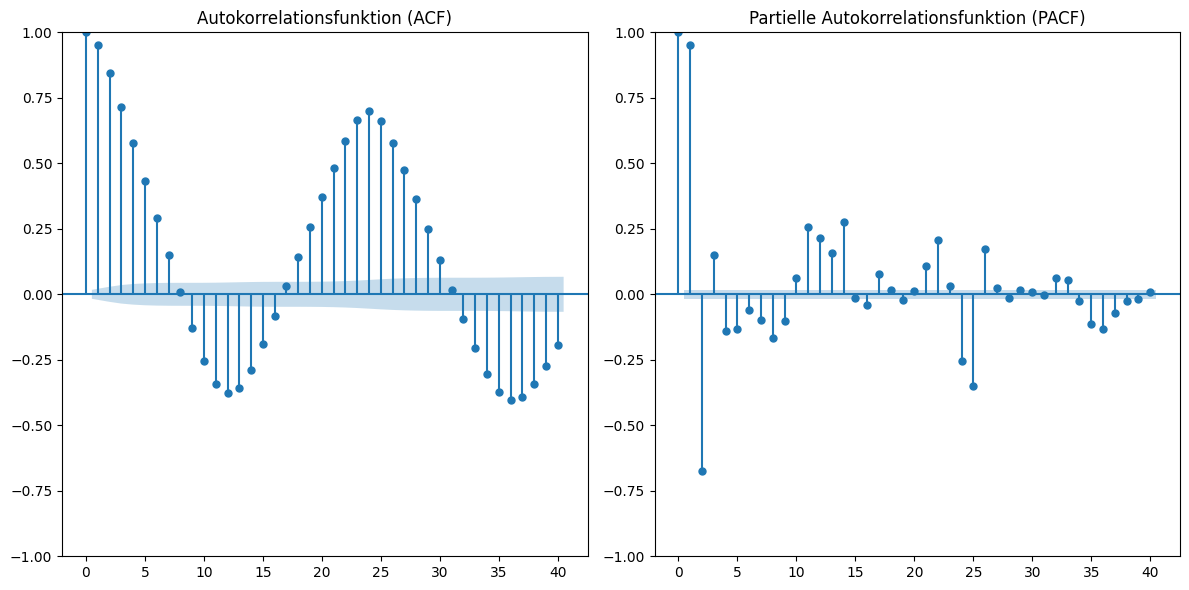

Stationaritätstest für activeSessions_site_2:
ADF-Test: p-Wert = 0.0000
ADF: Stationär
------


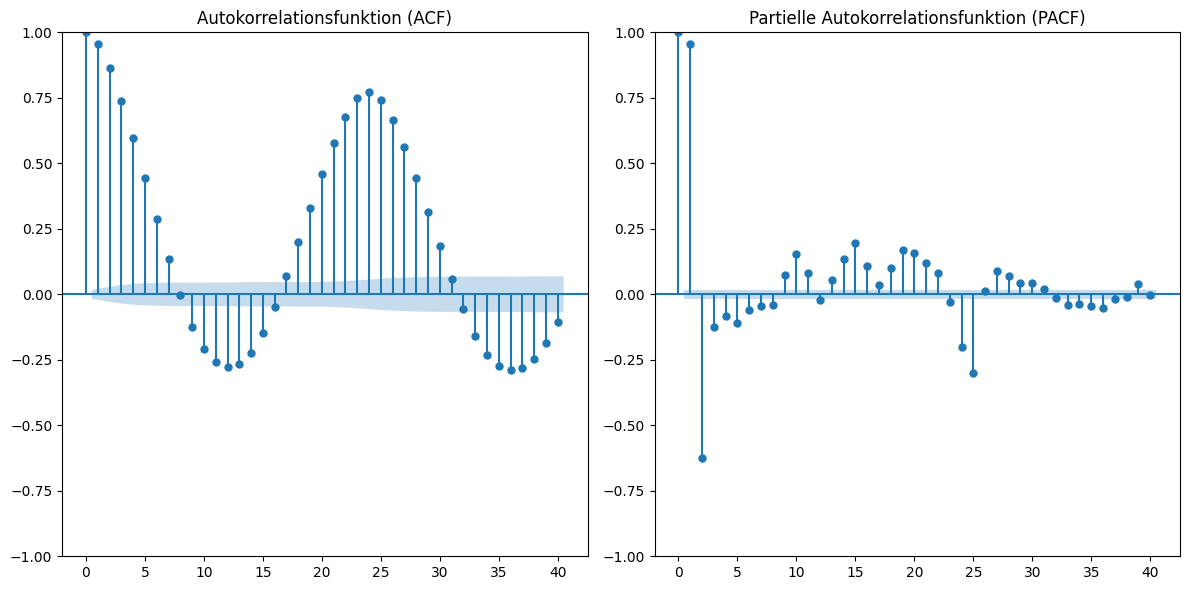

In [19]:
def check_stationarity(series, alpha=0.05, max_diff=5):
    diff_count = 0
    stationarity_changed = False  # Flag für Differenzierung gesetzt

    while diff_count < max_diff:
        # ADF-Test
        adf_result = adfuller(series)
        adf_pvalue = adf_result[1]
        print(f"ADF-Test: p-Wert = {adf_pvalue:.4f}")
        if adf_pvalue < alpha:
            print("ADF: Stationär")
            break
        else:
            print("ADF: Nicht stationär")

        # KPSS-Test
        kpss_result = kpss(series, nlags="auto")
        kpss_pvalue = kpss_result[1]
        print(f"KPSS-Test: p-Wert = {kpss_pvalue:.4f}")
        if kpss_pvalue > alpha:
            print("KPSS: Stationär")
            break
        else:
            print("KPSS: Nicht stationär")

        # Wenn nicht stationär, Differenzieren und erneut testen
        series = series.diff().dropna()  # NaN-Werte nach Differenzierung entfernen
        diff_count += 1
        stationarity_changed = True  # Markiere, dass Differenzierung durchgeführt wurde
        print(f"--- Differenzierung #{diff_count} ---")
        plot_series(series, f"Serie nach Differenzierung #{diff_count}")

    if diff_count == max_diff:
        print("Maximale Anzahl an Differenzierungen erreicht.")

    return stationarity_changed


def plot_series(series, title="Zeitreihe"):
    plt.figure(figsize=(10, 6))
    plt.plot(series)
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Wert')

# --- ACF und PACF Funktionen ---
def plot_acf_pacf(series, lags=40):
    plt.figure(figsize=(12, 6))

    # ACF plotten (Bestimmung von q)
    plt.subplot(121)
    plot_acf(series, lags=lags, ax=plt.gca(), title="Autokorrelationsfunktion (ACF)")

    # PACF plotten (Bestimmung von p)
    plt.subplot(122)
    plot_pacf(series, lags=lags, ax=plt.gca(), title="Partielle Autokorrelationsfunktion (PACF)")

    plt.tight_layout()
    plt.show()

# --- Stationarität und ACF/PACF für jede Zielvariable ---
for col in target_columns:
    print(f"Stationaritätstest für {col}:")

    # Kopiere die Originalserie, damit wir die Differenzierung in der Schleife vornehmen können
    series_copy = data[col].copy()

    # Prüfe Stationarität
    stationarity_changed = check_stationarity(series_copy)
    print("------")

    # Wenn Differenzierung vorgenommen wurde, Stationarität nach der Differenzierung testen
    if stationarity_changed:
        print(f"Stationaritätstest nach Differenzierung für {col}:")
        check_stationarity(series_copy)
        print("------")

    # ACF und PACF nach Stationarität prüfen und Differenzierung visualisieren
    plot_acf_pacf(series_copy)

# Alle Plots anzeigen
plt.show()


## Model architecture

The ARIMA model is designed to handle time series forecasting using the following components:

- **ARIMA Model Setup**: The ARIMA model is initialized with the specified parameters `(p, d, q)`, representing the autoregressive, differencing, and moving average orders.

- **Fit Method**: Fits the ARIMA model to the training data and outputs a detailed model summary, along with key metrics like AIC, BIC, and Log-Likelihood. Residual analysis is also performed to check the model fit.

- **Residual Analysis**: The residuals are extracted and visualized through both a time-series plot and a histogram to ensure that the residuals are normally distributed and centered around zero.

- **Prediction**: The `predict()` method generates forecasted values for the specified forecast horizon based on the fitted ARIMA model.

- **Plotting**: Actual vs. predicted values are plotted for a clear visual comparison.

This ARIMA model provides a comprehensive approach to time series forecasting with diagnostic checks and performance evaluation.


In [8]:
class ARIMAModel:
    def __init__(self, order=(2, 0, 1)):  # p, d, q für das ARIMA-Modell
        self.order = order
        self.model = None

    def fit(self, train_data):
        """Trainiert das ARIMA Modell"""
        self.model = ARIMA(train_data, order=self.order)
        self.fitted_model = self.model.fit()  # Entferne 'disp=False'
        self.train_index = train_data.index  # Speichern des Index der Trainingsdaten
        return self.fitted_model

    def forecast(self, steps=24):
        """Erzeugt Vorhersagen für die nächsten 'steps' Zeitpunkte"""
        forecast = self.fitted_model.forecast(steps=steps)

        # Sicherstellen, dass der letzte Zeitstempel ein datetime-Objekt ist
        last_time = self.train_index[-1]
        if not isinstance(last_time, pd.Timestamp):  # Wenn es kein Timestamp ist, konvertiere es
            last_time = pd.to_datetime(last_time)

        # Vorhersagezeitraum mit pd.Timedelta und pd.date_range
        forecast_index = pd.date_range(start=last_time + pd.Timedelta(hours=1), periods=steps, freq='H')

        # Erstelle eine Pandas-Serie mit dem Vorhersagewert und dem neu generierten Index
        forecast_mean = pd.Series(forecast, index=forecast_index)
        return forecast_mean

    def plot_diagnostics(self):
        """Zeigt diagnostische Plots an"""
        self.fitted_model.plot_diagnostics(figsize=(15, 12))
        plt.show()

    def plot_forecast(self, forecast_mean, true_values, target_col):
        """Visualisiert Vorhersagen und tatsächliche Werte"""
        plt.figure(figsize=(12, 6))

        # True values direkt plotten
        plt.plot(true_values.index, true_values, label="True values")

        # Vorhersage direkt plotten
        plt.plot(forecast_mean.index, forecast_mean, label="Forecast", linestyle='--')

        plt.title(f"Hourly Forecast vs Actuals for {target_col}")
        plt.xlabel("Hour")
        plt.ylabel("Active Sessions")
        plt.legend()
        plt.show()

In [23]:
# Cross-Validation-Funktion für ARIMA
def cross_validate_arima(arima_model, data, target_col, window_size, forecast_horizon):

    if data.index.freq is None:
        data = data.asfreq('h')
    actual = []
    predictions = []
    time_points = []

    # Iteriere über den Datensatz mit dem Rollfenster
    for start in range(0, len(data) - window_size - forecast_horizon, forecast_horizon):
        # Trainings- und Testdaten erstellen
        train = data[target_col].iloc[start:start + window_size]
        test = data[target_col].iloc[start + window_size:start + window_size + forecast_horizon]
        test_time = data.index[start + window_size:start + window_size + forecast_horizon]

        # ARIMA-Modell anpassen
        model = ARIMA(train, order=arima_model)
        results = model.fit()

        # Prognose erstellen
        forecast = results.forecast(steps=forecast_horizon)

        # Ergebnisse speichern
        predictions.extend(forecast)
        actual.extend(test)
        time_points.extend(test_time)

    # Plot der tatsächlichen Werte und Vorhersagen
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, actual, label='Tatsächliche Werte', color='blue', alpha=0.7)
    plt.plot(time_points, predictions, label='ARIMA Vorhersagen', color='red', alpha=0.7)
    plt.title(f"ARIMA Cross-Validation für {target_col}")
    plt.xlabel("Zeit")
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Cross-Validation für activeSessions_site_1:


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978:

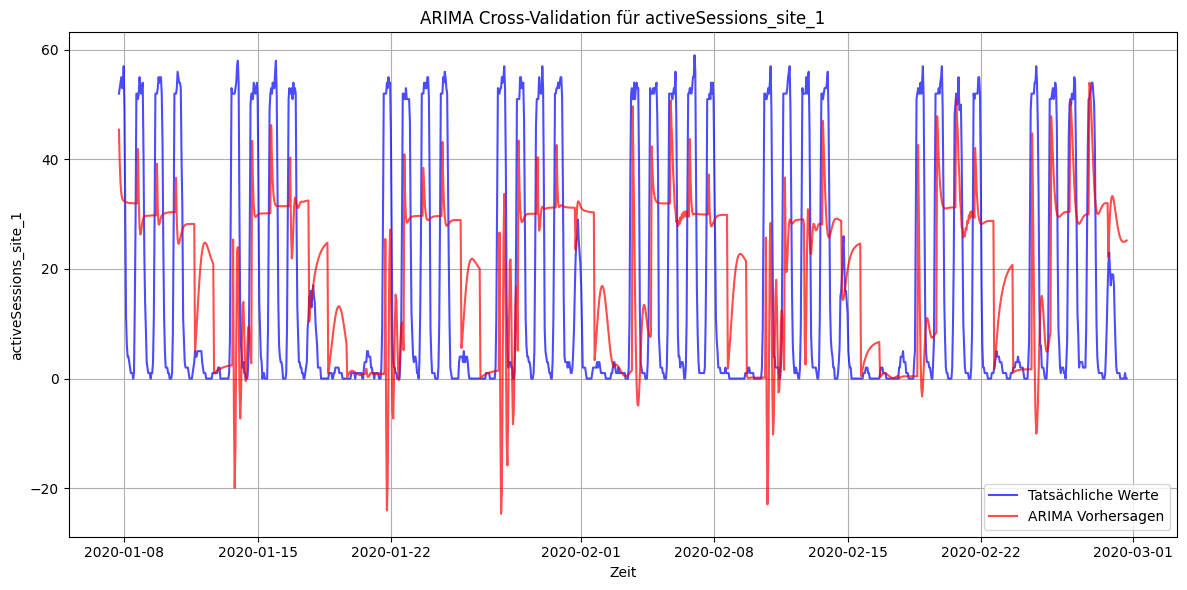

Cross-Validation für activeSessions_site_2:


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum L

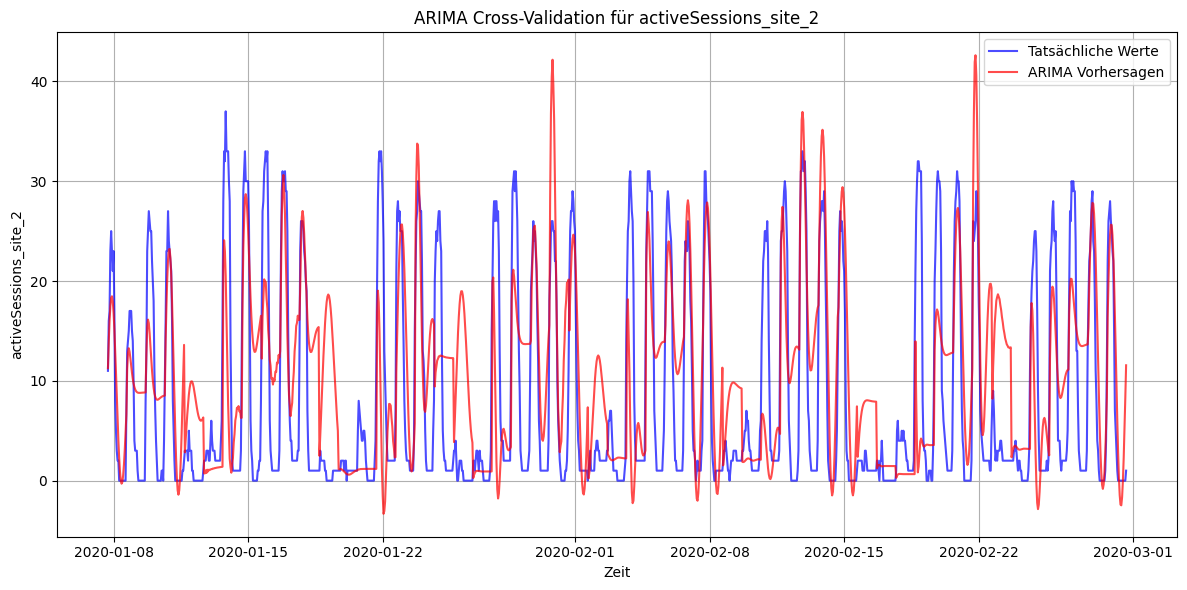

In [24]:
# Cross-Validation für 'activeSessions_site_1'
print("Cross-Validation für activeSessions_site_1:")
cross_validate_arima((1, 0, 2), test_data, target_col='activeSessions_site_1', window_size=24, forecast_horizon=24)

# Cross-Validation für 'activeSessions_site_2'
print("Cross-Validation für activeSessions_site_2:")
cross_validate_arima((2, 0, 2), test_data, target_col='activeSessions_site_2', window_size=24, forecast_horizon=24)

In [22]:
from itertools import product
from sklearn.metrics import mean_squared_error

# Funktion zum Testen verschiedener ARIMA-Parameterkombinationen
def test_arima_parameters_and_find_best(data, target_col, p_values, q_values, d=0, window_size=24, forecast_horizon=24):
    """
    Testet verschiedene ARIMA-Parameterkombinationen und gibt die beste basierend auf MSE zurück.

    Args:
        data (DataFrame): Datensatz mit 'hour' und Zielvariablen.
        target_col (str): Zielspaltenname.
        p_values (list): Liste von p-Werten (AR-Lags).
        q_values (list): Liste von q-Werten (MA-Lags).
        d (int): Differenzierungsgrad.
        window_size (int): Rollfenstergröße.
        forecast_horizon (int): Prognosezeitraum.

    Returns:
        dict: Beste ARIMA-Parameterkombination und zugehöriger MSE.
    """
    results_summary = []
    best_params = None
    best_mse = float('inf')  # Initialisiere mit einem sehr hohen Wert

    for p, q in product(p_values, q_values):
        print(f"Teste ARIMA({p}, {d}, {q}) für {target_col}...")

        actual = []
        predictions = []

        try:
            # Rollfenster für Cross-Validation
            for start in range(0, len(data) - window_size - forecast_horizon, forecast_horizon):
                # Trainings- und Testdaten erstellen
                train = data[target_col].iloc[start:start + window_size]
                test = data[target_col].iloc[start + window_size:start + window_size + forecast_horizon]

                # ARIMA-Modell anpassen
                model = ARIMA(train, order=(p, d, q))
                results = model.fit()

                # Prognose erstellen
                forecast = results.forecast(steps=forecast_horizon)

                # Ergebnisse speichern
                predictions.extend(forecast)
                actual.extend(test)

            # MSE berechnen
            mse = mean_squared_error(actual, predictions)
            print(f"ARIMA({p}, {d}, {q}) MSE: {mse:.4f}")

            # Beste Kombination aktualisieren
            if mse < best_mse:
                best_mse = mse
                best_params = (p, d, q)

            results_summary.append((p, d, q, mse))
        except Exception as e:
            print(f"Fehler bei ARIMA({p}, {d}, {q}): {e}")

    # Zusammenfassung der Ergebnisse
    print("\nZusammenfassung der getesteten Modelle:")
    for result in results_summary:
        print(f"ARIMA({result[0]}, {result[1]}, {result[2]}) MSE: {result[3]:.4f}")

    print(f"\nBeste Parameterkombination: ARIMA{best_params} mit MSE: {best_mse:.4f}")
    return {"best_params": best_params, "best_mse": best_mse}


# Parameterkombinationen festlegen
p_values = [1, 2, 3]  # Verschiedene AR-Lags
q_values = [1, 2, 3]  # Verschiedene MA-Lags

# Cross-Validation für 'activeSessions_site_1'
print("Cross-Validation für activeSessions_site_1:")
best_model_site_1 = test_arima_parameters_and_find_best(test_data, target_col='activeSessions_site_1', p_values=p_values, q_values=q_values)

# Cross-Validation für 'activeSessions_site_2'
print("\nCross-Validation für activeSessions_site_2:")
best_model_site_2 = test_arima_parameters_and_find_best(test_data, target_col='activeSessions_site_2', p_values=p_values, q_values=q_values)

# Ergebnisse der besten Modelle
print("\nBeste Modelle:")
print(f"activeSessions_site_1: Beste Parameter: {best_model_site_1['best_params']}, MSE: {best_model_site_1['best_mse']:.4f}")
print(f"activeSessions_site_2: Beste Parameter: {best_model_site_2['best_params']}, MSE: {best_model_site_2['best_mse']:.4f}")


Cross-Validation für activeSessions_site_1:
Teste ARIMA(1, 0, 1) für activeSessions_site_1...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('N

ARIMA(1, 0, 1) MSE: 469.0289
Teste ARIMA(1, 0, 2) für activeSessions_site_1...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dat

ARIMA(1, 0, 2) MSE: 443.8011
Teste ARIMA(1, 0, 3) für activeSessions_site_1...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('N

ARIMA(1, 0, 3) MSE: 469.9964
Teste ARIMA(2, 0, 1) für activeSessions_site_1...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dat

ARIMA(2, 0, 1) MSE: 541.5427
Teste ARIMA(2, 0, 2) für activeSessions_site_1...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dat

ARIMA(2, 0, 2) MSE: 486.9574
Teste ARIMA(2, 0, 3) für activeSessions_site_1...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameter

ARIMA(2, 0, 3) MSE: 452.6300
Teste ARIMA(3, 0, 1) für activeSessions_site_1...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dat

ARIMA(3, 0, 1) MSE: 507.3093
Teste ARIMA(3, 0, 2) für activeSessions_site_1...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dat

ARIMA(3, 0, 2) MSE: 459.9085
Teste ARIMA(3, 0, 3) für activeSessions_site_1...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameter

ARIMA(3, 0, 3) MSE: 469.7399

Zusammenfassung der getesteten Modelle:
ARIMA(1, 0, 1) MSE: 469.0289
ARIMA(1, 0, 2) MSE: 443.8011
ARIMA(1, 0, 3) MSE: 469.9964
ARIMA(2, 0, 1) MSE: 541.5427
ARIMA(2, 0, 2) MSE: 486.9574
ARIMA(2, 0, 3) MSE: 452.6300
ARIMA(3, 0, 1) MSE: 507.3093
ARIMA(3, 0, 2) MSE: 459.9085
ARIMA(3, 0, 3) MSE: 469.7399

Beste Parameterkombination: ARIMA(1, 0, 2) mit MSE: 443.8011

Cross-Validation für activeSessions_site_2:
Teste ARIMA(1, 0, 1) für activeSessions_site_2...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dat

ARIMA(1, 0, 1) MSE: 100.0168
Teste ARIMA(1, 0, 2) für activeSessions_site_2...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dat

ARIMA(1, 0, 2) MSE: 96.2052
Teste ARIMA(1, 0, 3) für activeSessions_site_2...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

ARIMA(1, 0, 3) MSE: 98.3429
Teste ARIMA(2, 0, 1) für activeSessions_site_2...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dat

ARIMA(2, 0, 1) MSE: 68.9881
Teste ARIMA(2, 0, 2) für activeSessions_site_2...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dat

ARIMA(2, 0, 2) MSE: 62.1061
Teste ARIMA(2, 0, 3) für activeSessions_site_2...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('N

ARIMA(2, 0, 3) MSE: 67.0709
Teste ARIMA(3, 0, 1) für activeSessions_site_2...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dat

ARIMA(3, 0, 1) MSE: 72.4202
Teste ARIMA(3, 0, 2) für activeSessions_site_2...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameter

ARIMA(3, 0, 2) MSE: 66.6941
Teste ARIMA(3, 0, 3) für activeSessions_site_2...


C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dat

ARIMA(3, 0, 3) MSE: 65.0945

Zusammenfassung der getesteten Modelle:
ARIMA(1, 0, 1) MSE: 100.0168
ARIMA(1, 0, 2) MSE: 96.2052
ARIMA(1, 0, 3) MSE: 98.3429
ARIMA(2, 0, 1) MSE: 68.9881
ARIMA(2, 0, 2) MSE: 62.1061
ARIMA(2, 0, 3) MSE: 67.0709
ARIMA(3, 0, 1) MSE: 72.4202
ARIMA(3, 0, 2) MSE: 66.6941
ARIMA(3, 0, 3) MSE: 65.0945

Beste Parameterkombination: ARIMA(2, 0, 2) mit MSE: 62.1061

Beste Modelle:
activeSessions_site_1: Beste Parameter: (1, 0, 2), MSE: 443.8011
activeSessions_site_2: Beste Parameter: (2, 0, 2), MSE: 62.1061


In [ ]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# --- Daten laden ---
df = pd.read_csv("data/processed/hourly_avg_power_cut.csv")

# Zielvariablen definieren
target_columns = ['activeSessions_site_1', 'activeSessions_site_2']

# Ergebnisse für beide Zielvariablen speichern
results = {}

for target in target_columns:
    print(f"\n🔹 Verarbeitung von {target}...")

    # Daten extrahieren
    data = df[target].dropna().values

    # Daten splitten
    train_size = int(len(data) * 0.7)
    val_size = int(len(data) * 0.2)

    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    # Testdaten für spätere Auswertung speichern
    pd.DataFrame(test_data, columns=[target]).to_csv(f"data/processed/test_dataset_shifted_ARIMA_{target}.csv", index=False)

    # --- Hyperparameter-Raum definieren ---
    p_values = [2, 3]
    d_values = [0]  # Da die Daten stationär sind
    q_values = [1, 2]

    # Cross-Validation Setup
    tscv = TimeSeriesSplit(n_splits=5)
    best_aic = np.inf
    best_order = None

    # --- Grid Search über (p, d, q) ---
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            aic_scores = []

            for train_idx, val_idx in tscv.split(train_data):
                train_fold, val_fold = train_data[train_idx], train_data[val_idx]

                model = ARIMA(train_fold, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit()

                aic_scores.append(model_fit.aic)

            mean_aic = np.mean(aic_scores)
            print(f"ARIMA({p},{d},{q}) - Durchschnittlicher AIC: {mean_aic}")

            # Bestes Modell speichern
            if mean_aic < best_aic:
                best_aic = mean_aic
                best_order = (p, d, q)

        except Exception as e:
            print(f"⚠️ Fehler bei ARIMA({p},{d},{q}): {e}")

    print(f"\n✅ Bestes Modell für {target}: ARIMA{best_order} mit AIC={best_aic}")

    # --- Bestes Modell trainieren ---
    final_model = ARIMA(train_data, order=best_order).fit()

    # --- Vorhersage ---
    forecast_horizon = len(test_data)  # Gleiche Länge wie Testdaten
    forecast = final_model.forecast(steps=forecast_horizon)

    # --- Evaluierung ---
    mse = mean_squared_error(test_data, forecast)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(test_data - forecast))
    bic = final_model.bic

    print(f"\n📊 Evaluierung für {target}:")
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, BIC: {bic}")

    # --- Ergebnisse speichern ---
    results[target] = {
        "Bestes Modell": best_order,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "BIC": bic
    }

    # --- 📊 Visualisierung ---
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Echte Werte", color="blue")
    plt.plot(np.arange(len(data) - forecast_horizon, len(data)), forecast, label="Vorhersage", color="red", linestyle="--")
    plt.title(f"ARIMA Vorhersage für {target}")
    plt.xlabel("Zeit")
    plt.ylabel("Wert")
    plt.legend()
    plt.grid()
    plt.show()

# --- Ergebnisse ausgeben ---
print("\n🔎 Zusammenfassung der Ergebnisse:")
for target, metrics in results.items():
    print(f"\n{target}:")
    for key, value in metrics.items():
        print(f"   {key}: {value}")


In [ ]:

def cross_validate_arima(data, order_list, forecast_horizon=1, cv_splits=3):
    """
    Führt Cross-Validation für ARIMA durch, um die besten (p, d, q)-Parameter zu finden.

    Args:
        data (array-like): Zeitreihen-Daten.
        order_list (list): Liste von (p, d, q)-Tupeln.
        forecast_horizon (int): Anzahl der Vorhersageschritte.
        cv_splits (int): Anzahl der Cross-Validation-Splits.

    Returns:
        dict: Beste Parameter und ihre Performance.
    """
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    results = []

    for order in order_list:
        cv_mse = []  # Speichert den MSE pro Split

        for train_idx, val_idx in tscv.split(data):
            train_data = data[train_idx]
            val_data = data[val_idx]

            # Modell trainieren
            try:
                model = ARIMA(train_data, order=order)
                model_fit = model.fit()

                # Vorhersage machen
                predictions = model_fit.forecast(steps=len(val_data))
                mse = np.mean((predictions - val_data) ** 2)
                cv_mse.append(mse)
            except Exception as e:
                print(f"Fehler mit ARIMA({order}): {e}")
                cv_mse.append(np.inf)  # Setze sehr hohen Fehler, wenn Modell fehlschlägt

        # Durchschnittlichen CV-Fehler speichern
        avg_mse = np.mean(cv_mse)
        results.append({"order": order, "mse": avg_mse})

    # Bestes Modell finden
    best_model = min(results, key=lambda x: x["mse"])
    return best_model, results

In [ ]:
if __name__ == "__main__":
    # Beispieldaten
    data = pd.Series(np.sin(np.linspace(0, 50, 100)) + np.random.normal(0, 0.1, 100))

    # Eingeschränkte ARIMA-Parameter-Liste (stationär)
    order_list = [
        (2, 0, 1),
        (2, 0, 2),
        (3, 0, 1),
        (3, 0, 2)
    ]

    # Cross-Validation durchführen
    best_model, results = cross_validate_arima(data.values, order_list, forecast_horizon=5, cv_splits=5)

    # Ergebnisse ausgeben
    print(f"Bestes Modell: ARIMA{best_model['order']} mit MSE: {best_model['mse']:.4f}")

    # Alle Ergebnisse anzeigen
    for result in results:
        print(f"ARIMA{result['order']} - MSE: {result['mse']:.4f}")

    # Finales Modell trainieren und vorhersagen
    final_order = best_model["order"]
    final_model = ARIMA(data.values, order=final_order)
    final_model_fit = final_model.fit()
    forecast = final_model_fit.forecast(steps=10)
    print("Vorhersagen:", forecast)


In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Funktion für 24-Stunden-Batches (basierend auf Reihenfolge der Zeilen)
def prepare_24h_batches(df):
    batches = []
    # Gehe durch den DataFrame und erstelle 24h-Batches
    for i in range(0, len(df) - 24, 24):  # Geht in Schritten von 24, um die Batches zu erstellen
        batch = df.iloc[i:i + 24]
        batches.append(batch)
    return batches

# ARIMA-Modell für Vorhersagen (statt LSTM)
def arima_predict(train_data, order=(2, 0, 3), forecast_horizon=24):
    """
    Fit ARIMA model on training data and predict the next forecast_horizon values.
    """
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()

    # Vorhersage für den angegebenen Zeitraum
    forecast = model_fit.forecast(steps=forecast_horizon)
    return forecast

# Funktion zum Erstellen der Plots für 24h Vorhersagen
def generate_plots_for_24h_predictions(test_batches, target_columns, order=(2, 0, 3)):
    """
    Macht Vorhersagen für 24h-Batches mit ARIMA und erstellt ein gemeinsames Diagramm.
    """

    # Initialisierung für alle Predictions und Stunden
    all_predictions = []
    all_actuals = []
    all_hours = []

    # Vorhersagen pro Batch
    for batch in test_batches:
        # Stunden als einfache Zeitreihe von 1 bis 24
        hours = np.arange(1, 25)

        # Vorhersagen pro Zielspalte
        predictions = {}
        for col in target_columns:
            forecast = arima_predict(batch[col], order=order)
            predictions[col] = forecast

        # Tatsächliche Werte
        actuals = batch[target_columns].values

        # Ergebnisse sammeln
        all_predictions.append(predictions)  # Vorhersagen für alle Zielspalten
        all_actuals.append(actuals)  # Tatsächliche Werte
        all_hours.append(hours)  # Stunden (1 bis 24)

    # DataFrames für alle Vorhersagen erstellen
    df_predictions = pd.DataFrame(all_predictions, columns=[f"pred_{col}" for col in target_columns])
    df_actuals = pd.DataFrame(all_actuals, columns=[f"actual_{col}" for col in target_columns])
    df_combined = pd.concat([df_predictions, df_actuals], axis=1)
    df_combined['hour'] = np.concatenate(all_hours)

    # Plot für activeSessions_site_1
    fig = go.Figure()
    for col in ['activeSessions_site_1']:
        fig.add_trace(go.Scatter(
            x=df_combined["hour"],
            y=df_combined[f"pred_{col}"],
            mode="lines",
            name=f"Prediction: {col}"
        ))
        fig.add_trace(go.Scatter(
            x=df_combined["hour"],
            y=df_combined[f"actual_{col}"],
            mode="lines",
            name=f"Actual: {col}"
        ))

    fig.update_layout(
        title="24h Predictions vs. Actuals - Active Sessions Site 1",
        xaxis_title="Hour",
        yaxis_title="Active Sessions",
        legend_title="Legend"
    )
    fig.show()

    # Plot für activeSessions_site_2
    fig = go.Figure()
    for col in ['activeSessions_site_2']:
        fig.add_trace(go.Scatter(
            x=df_combined["hour"],
            y=df_combined[f"pred_{col}"],
            mode="lines",
            name=f"Prediction: {col}"
        ))
        fig.add_trace(go.Scatter(
            x=df_combined["hour"],
            y=df_combined[f"actual_{col}"],
            mode="lines",
            name=f"Actual: {col}"
        ))

    fig.update_layout(
        title="24h Predictions vs. Actuals - Active Sessions Site 2",
        xaxis_title="Hour",
        yaxis_title="Active Sessions",
        legend_title="Legend"
    )
    fig.show()

# Funktion zur Visualisierung der aktiven Sitzungen für Site 1 (Matplotlib)
def plot_active_sessions_site_1(df_combined):
    hours = df_combined["hour"]
    pred_active_sessions_site_1 = df_combined["pred_activeSessions_site_1"]
    actual_active_sessions_site_1 = df_combined["actual_activeSessions_site_1"]

    # Plot der Daten
    plt.figure(figsize=(10, 6))
    plt.plot(hours, pred_active_sessions_site_1, label="Prediction: Active Sessions (Site 1)", linestyle='-')
    plt.plot(hours, actual_active_sessions_site_1, label="Actual: Active Sessions (Site 1)", linestyle='-')

    # Hinzufügen von Labels und Titel
    plt.title("Active Sessions on Site 1: Predictions vs Actuals")
    plt.xlabel("Hour")
    plt.ylabel("Active Sessions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Speichern des Plots als PNG
    plt.savefig("output/active_sessions_site_1.png")
    plt.show()

if __name__ == "__main__":
    # --- Parameter ---
    target_columns = ['activeSessions_site_1', 'activeSessions_site_2']

    # Testdaten laden
    df_test = pd.read_csv("data/processed/test_dataset_shiftedAMIRA.csv")

    # Um sicherzustellen, dass die Daten als float32 behandelt werden
    df_test[target_columns] = df_test[target_columns].astype('float32')

    # 24h-Batches vorbereiten (jetzt ohne 'hour'-Spalte, nur basierend auf den Zeilen)
    test_batches = prepare_24h_batches(df_test)

    # Vorhersagen und Plot generieren
    generate_plots_for_24h_predictions(
        test_batches=test_batches,
        target_columns=target_columns,
        order=(2, 0, 3)  # ARIMA (p, d, q) Parameter
    )
